In [ ]:
#mount gdrive in colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Case Studies ML/Project')

# Training

In [ ]:
#Unzip the dataset if not already done

import zipfile
if not os.path.exists('Dataset'):
  print('Unzipping Dataset')
  !unzip NewDataset.zip


In [ ]:
from typing_extensions import final
import csv
import pandas as pd
from glob import glob
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

In [ ]:
if not os.path.exists('combined_dataset.csv'):
  # Combine CSV files
  csv_files = glob('Dataset/dataset_*.csv')
  print(f'Number of CSV files: {len(csv_files)}')
  final_csv = pd.DataFrame()
  for csv_files in csv_files:
    df = pd.read_csv(csv_files)
    final_csv = pd.concat([final_csv, df], axis=0, ignore_index=True)
  final_csv.to_csv('combined_dataset.csv')

Number of CSV files: 10


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ObjectPositionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, stack_mode='vertical'):
        self.annotations = pd.read_csv(csv_file,index_col=0)
        self.root_dir = root_dir
        self.transform = transform
        self.stack_mode = stack_mode  # 'vertical' or 'horizontal'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, f"{self.annotations.iloc[index, 0]}_cam")
        image1 = Image.open(img_name + "1.jpg")
        image2 = Image.open(img_name + "2.jpg")

        # Stack images
        if self.stack_mode == 'vertical':
            combined_image = Image.new('RGB', (image1.width, image1.height + image2.height))
            combined_image.paste(image1, (0, 0))
            combined_image.paste(image2, (0, image1.height))
        else:  # horizontal
            combined_image = Image.new('RGB', (image1.width + image2.width, image1.height))
            combined_image.paste(image1, (0, 0))
            combined_image.paste(image2, (image1.width, 0))

        y_label = torch.tensor(self.annotations.iloc[index, 1:4].values.astype(float)).float()

        if self.transform:
            combined_image = self.transform(combined_image)

        return combined_image, y_label


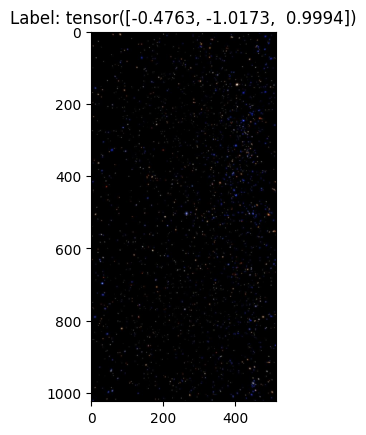

In [ ]:
import matplotlib.pyplot as plt
dataset = ObjectPositionDataset('combined_dataset.csv', 'Dataset')
def show_sample(dataset, idx):
    image1, label = dataset[idx]
    plt.imshow(image1)
    plt.title(f'Label: {label}')
    plt.show()
show_sample(dataset, 0)

In [ ]:
import torchvision.models as models
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_channels=3, pretrained=True):
        super(CustomModel, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)
        self.resnet = nn.Sequential(*list(resnet.children())[1:-1])  # Remove first and last layer

        # Adjusting the first convolutional layer
        self.resnet[0] = nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.fc = nn.Linear(resnet.fc.in_features, 3)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [ ]:
#Deprecated DONT USE
def train(model, dataloader, loss_fn, optimizer, epochs, checkpoint_path="model_checkpoint.pth.tar", save_epoch_interval=5):
    for epoch in range(epochs):
        loop = tqdm(dataloader, leave=True)
        for (images, labels) in loop:
            image1, image2 = images[0].to(device), images[1].to(device)
            labels = labels.to(device)

            preds = model(image1, image2)
            loss = loss_fn(preds, labels.float())  # Ensure labels are float

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_description(f'Epoch [{epoch+1}/{epochs}]')
            loop.set_postfix(loss=loss.item())

        if (epoch + 1) % save_epoch_interval == 0:
            save_checkpoint({'state_dict': model.state_dict()}, filename=f"{checkpoint_path}_epoch{epoch+1}.pth.tar")


In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer=None):
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer'])
    return model

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import random_split

# Define the sizes for train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size


# Constants
BATCH_SIZE = 12
LEARNING_RATE = 0.001
EPOCHS = 50
DATA_ROOT_DIR = 'Dataset'  # Replace with your image directory path

# Step 1: Set Up Dataset and Dataloader
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = ObjectPositionDataset(csv_file='combined_dataset.csv', root_dir=DATA_ROOT_DIR, transform=transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Step 2: Create Model Instance
model = CustomModel().to(device)

# Step 3: Define Loss Function and Optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Step 4: Train the Model (Few cells down)
#train(model, dataloader, loss_fn, optimizer, EPOCHS)

# Step 5: Save Checkpoints
#save_checkpoint({'state_dict': model.state_dict()}, filename="model_checkpoint.pth.tar")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


In [ ]:
train_losses = []
val_losses = []

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, epoch_offset=0,checkpoint_path="model_checkpoint", save_epoch_interval=5):
    # Load latest checkpoint from given directory if exists
    if os.path.isfile(checkpoint_path+"/epoch2.pth.tar"):
        if input("Checkpoint found. Load from checkpoint? (y/N) ") == 'y':
          checkpoint = torch.load(checkpoint_path+"/epoch2.pth.tar")
          model.load_state_dict(checkpoint['state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer'])
          print(f'Model loaded from {checkpoint_path}.')
    elif input("No checkpoint found. Train from scratch? (y/N) ") == 'y':
        pass
    else:
        raise FileNotFoundError

    for epoch in range(epoch_offset, epochs+epoch_offset):
        model.train()

        loop = tqdm(train_loader, leave=True)
        for (image, labels) in loop:
            image = image.to(device)
            labels = labels.to(device)

            preds = model(image)
            loss = loss_fn(preds, labels.float())  # Ensure labels are float

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_description(f'Epoch [{epoch+1}/{epochs}]')
            loop.set_postfix(loss=loss.item())
            train_losses.append(loss.item())
            #save train losses to file
            with open(f'train_losses_{epoch_offset}.txt', 'w') as f:
                for item in train_losses:
                    f.write("%s\n" % item)

        if (epoch + 1) % save_epoch_interval == 0:
            checkpoint = {
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict()  # Assuming optimizer is defined
            }
            save_checkpoint(checkpoint, filename=f"{checkpoint_path}/epoch{epoch+1}.pth.tar")

        model.eval()
        with torch.no_grad():
            # Validation loop
            val_loss = 0
            for (image, labels) in val_loader:
                image = image.to(device)
                labels = labels.to(device)
                preds = model(image)
                val_loss += loss_fn(preds, labels.float()).item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            #save val losses to file
            with open('val_losses.txt', 'w') as f:
                for item in val_losses:
                    f.write("%s\n" % item)
            print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')


In [ ]:
!mkdir CombinedImage
!mkdir CombinedImage/checkpoint

In [ ]:
!ls CombinedImage/checkpoint

epoch1.pth.tar	epoch2.pth.tar	epoch3.pth.tar	final_checkpoint.pth.tar


In [ ]:
# Step 4 : Train and Validate the Model
train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, EPOCHS,checkpoint_path="CombinedImage/checkpoint", save_epoch_interval=1)
# Step 5: Save Checkpoints
save_checkpoint({'state_dict': model.state_dict()}, filename="CombinedImage/checkpoint/final_checkpoint.pth.tar")

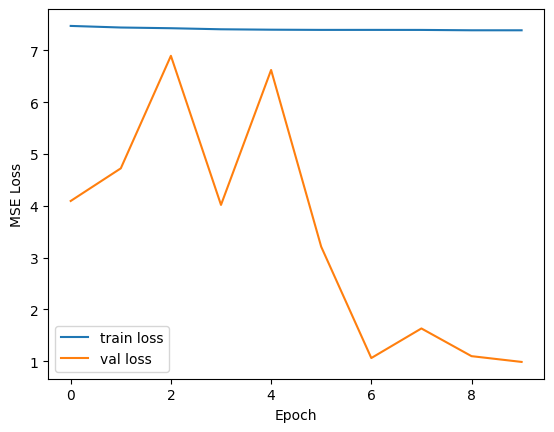

In [ ]:
#Plot Losses

train_losses = np.genfromtxt('train_losses.txt', delimiter='\n')
#train_losses = np.concatenate((train_losses, np.zeros(584 - len(train_losses) % 584)))
train_losses = train_losses.reshape((-1, 584))
train_losses = np.mean(train_losses, axis=1)
val_losses = np.genfromtxt('val_losses.txt', delimiter='\n')
import matplotlib.pyplot as plt
def plot_losses(train_losses:np.array, val_losses):
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()
plot_losses(train_losses, val_losses)

# Data Plotting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_losses(train_losses:np.array, val_losses):
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

In [ ]:
import plotly.graph_objs as go
df = pd.read_csv('combined_dataset.csv')
scatter = go.Scatter3d(
    x=df['x'],
    z=df['z'],
    y=[0]*len(df),  # Setting z coordinate to zero for all points
    mode='markers',
    marker=dict(
        size=1  # Adjust this value to change the size of the points
    )
)

fig = go.Figure(data=[scatter])
fig.show()

# Testing

In [ ]:
!ls

combined_dataset.csv  Dataset	      linux_build_Data	  train_losses_0.txt  UnityPlayer.so
CombinedImage	      epoch8.pth.tar  linux_build.x86_64  train_losses.txt    val_losses.txt


In [ ]:
chkpt = torch.load('epoch8.pth.tar')
model.load_state_dict(chkpt['state_dict'])

<All keys matched successfully>

Predicted:  [-0.5843964   0.13988319  0.6827529 ]
Actual:  [-0.6184307  0.2901287  0.7132505]


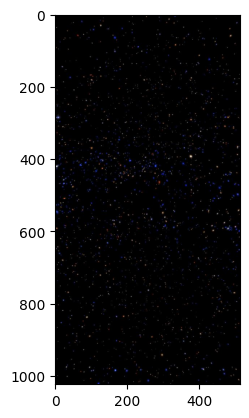

In [ ]:
plt.imshow(test_dataset[index][0].permute(1, 2, 0))
y_pred = model(test_dataset[index][0].unsqueeze(0).to(device))
y = test_dataset[index][1]
print("Predicted: ", y_pred.cpu().detach().numpy().ravel())
print("Actual: ", y.numpy())